<a href="https://colab.research.google.com/github/DanielRajChristeen/Custom_MobileNetV2/blob/main/Custom_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Trained MobileNetV2 — Classify Dog and Cat Images**

## **Step 1 — What is MobileNetV2?**

*   MobileNetV2 is a lightweight deep learning model trained on ImageNet (1000 classes).
*  It’s optimized for speed and small size, making it perfect for demos and real-world mobile apps.
*  We’ll use it as pre-trained model to instantly classify multiple images.

## **Step 2 — Setup and Imports**
Install and import the required libraries to build and train the model.

In [9]:
import os, shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

## **Step 3 — Load and Preprocess Dataset**
Setup ImageDataGenerators using preprocess_input to match MobileNetV2’s expected input format.

In [2]:
# Dataset paths
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Cleanup unwanted checkpoint folders
for split_dir in [train_dir, test_dir]:
    checkpoint_path = os.path.join(split_dir, ".ipynb_checkpoints")
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)

# Image properties
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("Train classes:", train_gen.class_indices)
print("Test classes:", test_gen.class_indices)

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Train classes: {'cat': 0, 'dog': 1}
Test classes: {'cat': 0, 'dog': 1}


## **Step 4 — Build MobileNetV2 Model**
Use MobileNetV2 as the base model and stack custom layers for binary classification.

In [3]:
# Load MobileNetV2 base
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze feature extractor

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)  # binary output

model = Model(inputs=base_model.input, outputs=preds)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Step 5 — Train the Model**
Train the model on your dataset and store the training history.

In [4]:

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4676 - loss: 0.9331 - val_accuracy: 0.5643 - val_loss: 0.7239
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5256 - loss: 0.8102 - val_accuracy: 0.6429 - val_loss: 0.6525
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5653 - loss: 0.6937 - val_accuracy: 0.6571 - val_loss: 0.6002
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6505 - loss: 0.6487 - val_accuracy: 0.7143 - val_loss: 0.5557
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7178 - loss: 0.5636 - val_accuracy: 0.7786 - val_loss: 0.5168
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7088 - loss: 0.5430 - val_accuracy: 0.8143 - val_loss: 0.4829
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8193 - loss: 0.4959 - val_accuracy: 0.8286 - val_loss: 0.4540
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7715 - loss: 0.4872 - val_accuracy: 0.8429 - val_loss:

In [5]:
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train again
fine_tune_history = model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen
)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7643 - loss: 0.4950 - val_accuracy: 0.9143 - val_loss: 0.3032
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8579 - loss: 0.4127 - val_accuracy: 0.9500 - val_loss: 0.2471
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8952 - loss: 0.3242 - val_accuracy: 0.9571 - val_loss: 0.2110
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9094 - loss: 0.2802 - val_accuracy: 0.9500 - val_loss: 0.1847
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9024 - loss: 0.2652 - val_accuracy: 0.9500 - val_loss: 0.1689


## **Step 6 — Evaluate and Visualize Results**
Check model performance and visualize accuracy and loss trends.

In [6]:
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 954ms/step - accuracy: 0.9395 - loss: 0.1784
✅ Test Accuracy: 95.00%


# **Step 7 — Predict on New Images**
Run predictions on custom images using the same preprocessing for consistency.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


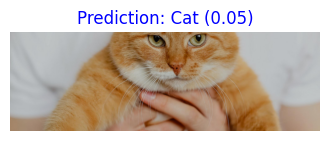

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


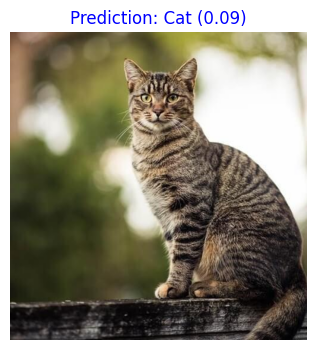

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


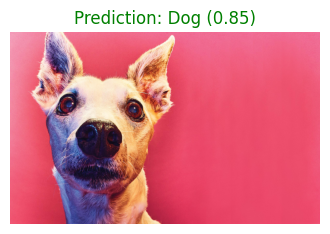

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


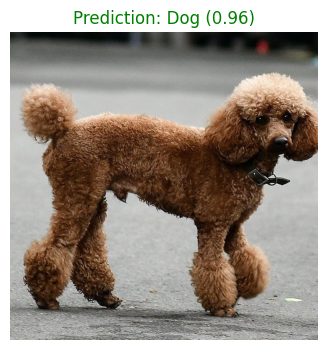

In [10]:
# --- Predict function using preprocess_input ---
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    pred = model.predict(img_array)[0][0]
    label = "Dog" if pred > 0.5 else "Cat"

    plt.figure(figsize=(4, 4))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {label} ({pred:.2f})",
              color="green" if label == "Dog" else "blue")
    plt.axis("off")
    plt.show()

# Example usage
predict_image('/content/sample1.jpg')
predict_image('/content/sample2.jpg')
predict_image('/content/sample3.jpg')
predict_image('/content/sample4.jpg')